## Running an example of general segmentation using SAM2

In this example, the model segments everything it finds in the image.


In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Geting the image from Solafune competition uploaded to my s3 bucket

# Finetuning by retraining the model with solafune's data

In [3]:
import numpy as np
import os
import cv2
import s3fs
import json
import rasterio
from shapely.geometry import Polygon
from PIL import Image, ImageDraw

def polygon_to_mask(polygon, width, height):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return np.array(mask)

def load_image(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    with rasterio.open(image_s3_uri) as src:
        image = src.read()
        image = np.moveaxis(image, 0, -1)
        image = image[:, :, :3]  # Assuming only the first 3 bands are needed (R, G, B)
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image_normalized = image_normalized.astype(np.uint8)
    return image_normalized

def load_annotations(annotation_s3_uri):
    """Load annotations from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        return json.load(f)
def load_original_annotations(annotation_s3_uri):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    return data
import numpy as np

def select_random_masks(masks, points=None, num_masks=5):
    total_masks = masks.shape[0]
    
    if total_masks <= num_masks:
        # If there are fewer masks than num_masks, return all of them
        return masks, points if points is not None else masks
    
    # Randomly select num_masks indices
    selected_indices = np.random.choice(total_masks, num_masks, replace=False)
    
    # Select the corresponding masks
    selected_masks = masks[selected_indices]
    
    # Select the corresponding points if provided
    selected_points = points[selected_indices] if points is not None else None
    
    return selected_masks, selected_points if selected_points is not None else selected_masks



In [4]:
def read_batch(data, image_s3_prefix):
    """Read a random image, its annotations, and generate masks and points."""
    # Select a random entry
    entry = data[np.random.randint(len(data))]
    image_filename = entry['file_name']
    image_s3_uri = os.path.join(image_s3_prefix, image_filename)
    
    # Load image
    Img = load_image(image_s3_uri)
    height, width = Img.shape[:2]
    
    # Load annotations
    annotations = entry['annotations']
    
    # Prepare masks and points
    masks = []
    points = []
    for annotation in annotations:
        mask = polygon_to_mask(annotation['segmentation'], width, height)
        masks.append(mask)
        
        # Generate a random point inside the mask
        coords = np.argwhere(mask > 0)
        yx = coords[np.random.randint(len(coords))]
        points.append([[yx[1], yx[0]]])

    # No need to convert to tensors here
    return Img, np.array(masks), np.array(points), np.ones([len(masks), 1])

In [5]:
def read_reduced_batch(data, image_s3_prefix, num_annotations=5):
    """Read a random image, its annotations, and generate masks and points with a reduced number of annotations."""
    # Select a random entry
    entry = data[np.random.randint(len(data))]
    image_filename = entry['file_name']
    image_s3_uri = os.path.join(image_s3_prefix, image_filename)
    
    # Load image
    Img = load_image(image_s3_uri)
    height, width = Img.shape[:2]
    
    # Load annotations
    annotations = entry['annotations']
    
    # Randomly select up to num_annotations from the available annotations
    if len(annotations) > num_annotations:
        selected_annotations = np.random.choice(annotations, num_annotations, replace=False)
    else:
        selected_annotations = annotations
    
    # Prepare masks and points
    masks = []
    points = []
    for annotation in selected_annotations:
        mask = polygon_to_mask(annotation['segmentation'], width, height)
        masks.append(mask)
        
        # Generate a random point inside the mask
        coords = np.argwhere(mask > 0)
        yx = coords[np.random.randint(len(coords))]
        points.append([[yx[1], yx[0]]])

    # No need to convert to tensors here
    return Img, np.array(masks), np.array(points), np.ones([len(masks), 1])

In [6]:
# Load Json
import s3fs
import json
train_annotation_s3_uri = 's3://solafune/train_annotation.json'

from torch.utils.data import DataLoader

# List of image filenames
image_filenames = [img['file_name'] for img in load_original_annotations(train_annotation_s3_uri)['images']]

#image_filenames = ['train_28.tif'] # set a quick training with specific images
image_s3_prefix = 's3://solafune/train_images/images'

 - Image shape : (801, 1293, 3)
 - Masks shape: (1118, 801, 1293)


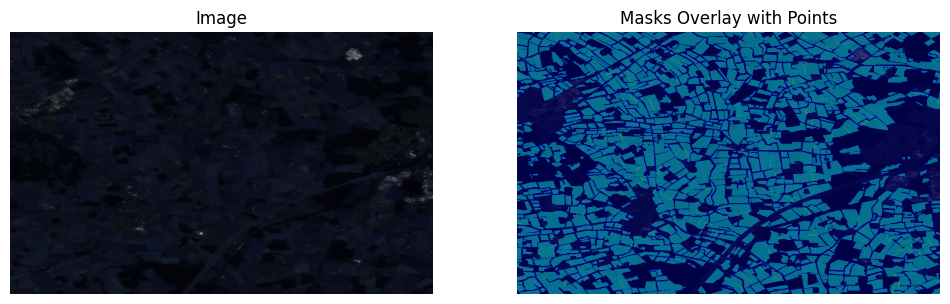

/tmp/ipykernel_26502/2493433692.py:22: RuntimeWarning: invalid value encountered in cast
  image_normalized = image_normalized.astype(np.uint8)


 - Image shape : (803, 1063, 3)
 - Masks shape: (5, 803, 1063)


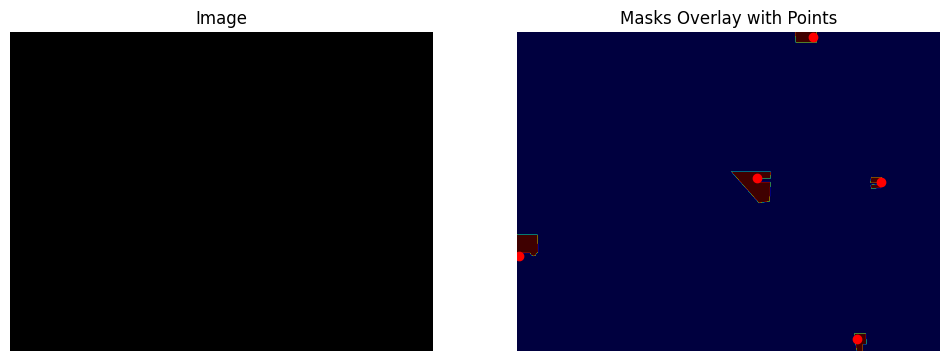

In [7]:
import matplotlib.pyplot as plt


def visualize_batch(image, masks, points=None):
    print(f" - Image shape : {image.shape}")
    print(f" - Masks shape: {masks.shape}")
    
    plt.figure(figsize=(12, 6))
    
    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')
    
    # Show the masks overlayed on the image
    combined_mask = masks.sum(axis=0)
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(combined_mask, alpha=0.5, cmap='jet')
    
    # Plot the points if provided
    if points is not None:
        for point in points:
            plt.plot(point[0][0], point[0][1], 'ro')  # red dots for points
    
    plt.title("Masks Overlay with Points")
    plt.axis('off')
    
    plt.show()



# Load the annotations data
data = load_annotations(train_annotation_s3_uri)['images']

image, masks, points, _ = read_batch(data, image_s3_prefix)


# Visualize the batch
visualize_batch(image, masks)

image, masks, points, _ = read_reduced_batch(data, image_s3_prefix)


visualize_batch(image, masks, points)




# Main Train Loop

In [8]:
# Load model
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt"  # path to model weight
model_cfg = "sam2_hiera_l.yaml"  # model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")  # load model
predictor = SAM2ImagePredictor(sam2_model)

#If saved
# saved_state = torch.load("model_large.torch")
# predictor.model.load_state_dict(saved_state)

# Set training parameters

predictor.model.sam_mask_decoder.train(True)  # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True)  # enable training of prompt encoder
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler()  # mixed precision

In [9]:
def check_weight_updates(model, old_state_dict):
    updated = False
    for name, param in model.named_parameters():
        if not torch.equal(param.data, old_state_dict[name].data):
            updated = True
            break
    return updated

In [10]:
# # Training loop

# for itr in range(100000):
#     with torch.cuda.amp.autocast():  # cast to mix precision
#         # Use the custom read_batch function
#         image, mask, input_point, input_label = read_reduced_batch(data, image_s3_prefix)  # in a better computer you can run for all the masks

#         if mask.shape[0] == 0: continue  # ignore empty batches

#         predictor.set_image(image)  # apply SAM image encoder to the image

#         # prompt encoding
#         mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
#             input_point, input_label, box=None, mask_logits=None, normalize_coords=True
#         )
#         sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
#             points=(unnorm_coords, labels), boxes=None, masks=None,
#         )

#         # mask decoder
#         batched_mode = unnorm_coords.shape[0] > 1  # multi object prediction
#         high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
#         low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
#             image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
#             image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
#             sparse_prompt_embeddings=sparse_embeddings,
#             dense_prompt_embeddings=dense_embeddings,
#             multimask_output=True,
#             repeat_image=batched_mode,
#             high_res_features=high_res_features,
#         )
#         prd_masks = predictor._transforms.postprocess_masks(
#             low_res_masks, predictor._orig_hw[-1]
#         )  # Upscale the masks to the original image resolution

#         # Segmentation Loss calculation
#         gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
#         prd_mask = torch.sigmoid(prd_masks[:, 0])  # Turn logit map to probability map
#         seg_loss = (
#             -gt_mask * torch.log(prd_mask + 0.00001)
#             - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)
#         ).mean()  # cross entropy loss

#         # Score loss calculation (intersection over union) IOU
#         inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
#         iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
#         score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
#         loss = seg_loss + score_loss * 0.05  # mix losses

#         # Save model's current state_dict before the update
#         if itr % 1000 == 0:
#             old_state_dict = {name: param.clone() for name, param in predictor.model.named_parameters()}

#         # apply backpropagation
#         predictor.model.zero_grad()  # empty gradient
#         scaler.scale(loss).backward()  # Backpropagate
#         scaler.step(optimizer)
#         scaler.update()  # Mix precision

#         # Check if weights have been updated
#         if itr % 1000 == 0:
#             if check_weight_updates(predictor.model, old_state_dict):
#                     print(f"Iteration {itr}: Weights have been updated.")
#             else:
#                     print(f"Iteration {itr}: No weight updates detected.")

#         if itr % 1000 == 0: 
#             #torch.save(predictor.model.state_dict(), "model.torch")
#             print("Model saved.")

#         # Display results
#         if itr == 0: 
#             mean_iou = 0
#         mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
#         print(f"step {itr} Accuracy(IOU)= {mean_iou:.8f}")

In [11]:
#torch.save(predictor.model.state_dict(), "model.torch")

## Test the results

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to calculate IoU between two masks
def calculate_iou(gt_mask, pred_mask):
    inter = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()
    iou = inter / (union + 1e-5)
    return iou.item()

# Function to visualize the image, GT mask, and predicted masks from different models
def visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, point):
    plt.figure(figsize=(20, 4))

    # Plot image with random point
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.scatter(point[0], point[1], color='red')
    plt.title("Image with Random Point")

    # Plot GT mask
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot Predicted mask (Current saved state)
    plt.subplot(1, 4, 3)
    plt.imshow(prd_mask_saved, cmap='gray')
    plt.title("Current Saved State")

    # Plot Predicted mask (SAM2 checkpoint)
    plt.subplot(1, 4, 4)
    plt.imshow(prd_mask_checkpoint, cmap='gray')
    plt.title("SAM2 Checkpoint")

    plt.show()

# Test the read_batch function and visualize the result
image, mask, input_point, input_label = read_reduced_batch(data, image_s3_prefix)

# Convert ground truth mask to binary
gt_mask = mask[0].astype(np.uint8)

# Use the first point in the batch
input_point = np.array(input_point[0])
input_label = np.array([1])



# 2. Load the SAM2 checkpoint and predict
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt"  # Adjust to large if needed
model_cfg = "sam2_hiera_l.yaml"  # Adjust to large if needed
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)
masks_pred_checkpoint, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)
prd_mask_checkpoint = masks_pred_checkpoint[0].astype(np.uint8)

# 1. Load the saved model state and predict
# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

saved_state = torch.load("model.torch")
predictor.model.load_state_dict(saved_state)

with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
        predictor.set_image(image) # image encoder
            # Use the first point in the batch
        input_points = np.array([[500, 375]])
        input_labels = np.array([1])
        masks_pred_saved, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )
        prd_mask_saved = masks_pred_saved[0].astype(np.uint8)
      


# # Calculate IoU
iou_saved_state = calculate_iou(gt_mask, prd_mask_saved)
iou_checkpoint = calculate_iou(gt_mask, prd_mask_checkpoint)

#
print(f"IoU (Current Saved State): {iou_saved_state:.4f}")
print(f"IoU (SAM2 Checkpoint): {iou_checkpoint:.4f}")

# Visualize all the results
visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, input_point[0])


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacity of 21.96 GiB of which 5.75 MiB is free. Process 8831 has 6.68 GiB memory in use. Process 10213 has 4.34 GiB memory in use. Process 28619 has 4.45 GiB memory in use. Process 1033 has 6.46 GiB memory in use. Of the allocated memory 6.15 GiB is allocated by PyTorch, and 81.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

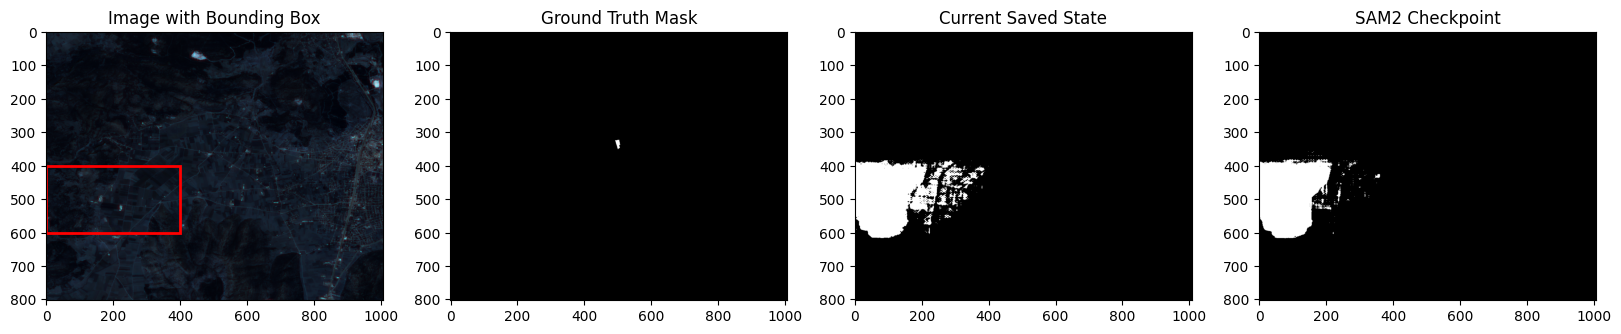

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to calculate IoU between two masks
def calculate_iou(gt_mask, pred_mask):
    inter = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()
    iou = inter / (union + 1e-5)
    return iou.item()

# Function to visualize the image, GT mask, and predicted masks from different models
def visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, box):
    plt.figure(figsize=(20, 4))

    # Plot image with bounding box
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                                      linewidth=2, edgecolor='red', facecolor='none'))
    plt.title("Image with Bounding Box")

    # Plot GT mask
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot Predicted mask (Current saved state)
    plt.subplot(1, 4, 3)
    plt.imshow(prd_mask_saved, cmap='gray')
    plt.title("Current Saved State")

    # Plot Predicted mask (SAM2 checkpoint)
    plt.subplot(1, 4, 4)
    plt.imshow(prd_mask_checkpoint, cmap='gray')
    plt.title("SAM2 Checkpoint")

    plt.show()

# Test the read_batch function and visualize the result
image, mask, input_point, input_label = read_reduced_batch(data, image_s3_prefix)

# Convert ground truth mask to binary
gt_mask = mask[0].astype(np.uint8)

# Define the bounding box coordinates
box = np.array([0, 400, 400, 600])  # [x1, y1, x2, y2]

# 2. Load the SAM2 checkpoint and predict
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt"  # Adjust to large if needed
model_cfg = "sam2_hiera_l.yaml"  # Adjust to large if needed
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)
masks_pred_checkpoint, _, _ = predictor.predict(
    box=box,
    multimask_output=False
)
prd_mask_checkpoint = masks_pred_checkpoint[0].astype(np.uint8)

# 1. Load the saved model state and predict
# use bfloat16 for the entire script (memory efficient)
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

saved_state = torch.load("model.torch")
predictor.model.load_state_dict(saved_state)

with torch.no_grad():  # prevent the net from calculating gradient (more efficient inference)
    predictor.set_image(image)  # image encoder
    
    # Predict using the bounding box
    masks_pred_saved, _, _ = predictor.predict(
        box=box,
        multimask_output=False
    )
    prd_mask_saved = masks_pred_saved[0].astype(np.uint8)

# Visualize all the results
visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, box)
